In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import numpy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import scipy.stats
import scipy
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10

#p_x1 = torch.distributions.von_mises.VonMises(0,2)
#p_x2 = torch.distributions.von_mises.VonMises(5,2)
mix = torch.distributions.categorical.Categorical(torch.ones(2))
compo = torch.distributions.von_mises.VonMises(torch.tensor([-2.5,2.5]), torch.tensor([1,1]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(mix, compo)


#Training parameters
N_EPOCHS = 100
N_SAMPLES = 5000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
p_x



MixtureSameFamily(
  Categorical(probs: torch.Size([2]), logits: torch.Size([2])),
  VonMises(loc: torch.Size([2]), concentration: torch.Size([2])))

Text(0, 0.5, 'pdf')

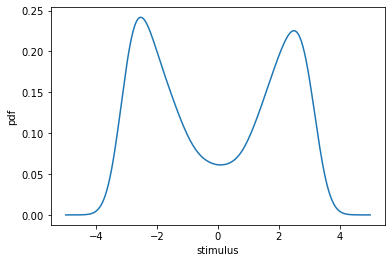

In [4]:
kde = scipy.stats.gaussian_kde(x_samples[:,0])
t_range = np.linspace(-5,5,200)
plt.plot(t_range,kde(t_range))
plt.xlabel("stimulus")
plt.ylabel("pdf")



Text(0, 0.5, 'Encoding')

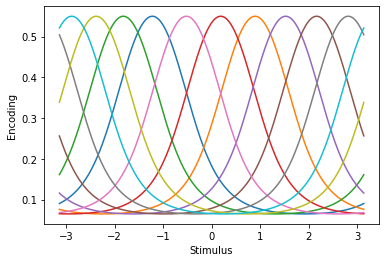

In [5]:
#CIRCULAR ENCODER
enc_circ = CircularBernoulliEncoder(N,x_sorted)
dec = MLPDecoder_circ(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")


In [6]:
#Modified Bessel function (to compute distortion)

class ModifiedBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, k, nu):
        ctx._nu = nu
        ctx.save_for_backward(k)
        return torch.from_numpy(scipy.special.iv(nu, k.detach().numpy()))
    @staticmethod
    def backward(ctx, grad_out):
        k, = ctx.saved_tensors
        nu = ctx._nu
        
        return 0.5* grad_out *(ModifiedBessel.apply(k, nu - 1.0)+ModifiedBessel.apply(k, nu + 1.0)), None

modified_bessel = ModifiedBessel.apply


#Circular distortion

def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,log_k = decoder(r)
    #log_k =2.29*torch.ones(1)
    #k = 1/sigma2_dec
    logq_x_r = torch.exp(log_k)*torch.cos(x-mu_dec) - torch.log(modified_bessel(torch.exp(log_k),0)) - torch.log(2*torch.as_tensor(math.pi))
    D = -logq_x_r.mean()
    return D

In [7]:
q = rate_ising(N)
rate = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [8]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(5000):
    
    dist = distortion_circular(x_fine,enc_circ,dec)
    loss = dist
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    lossVec.append(loss.item())


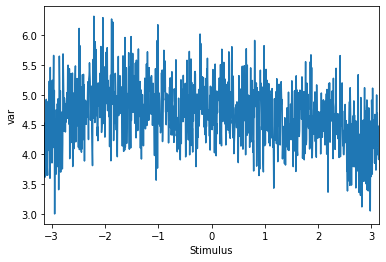

In [9]:
r= enc_circ.sample(x_fine,50)
mu_dec,log_k_dec = dec(r)

#variance of the pre-trained decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,torch.exp(log_k_dec).mean(dim=1).detach())
    plt.ylabel("var")
    plt.xlabel("Stimulus")
    plt.xlim(-math.pi,math.pi)

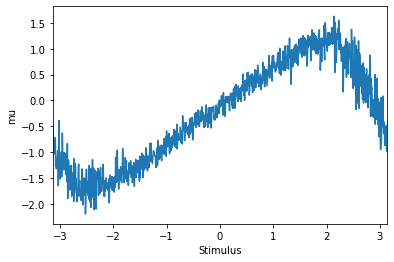

In [10]:
#means of the pre-trained decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,mu_dec.mean(dim=1).detach())
    plt.ylabel("mu")
    plt.xlabel("Stimulus")
    plt.xlim(-math.pi,math.pi)


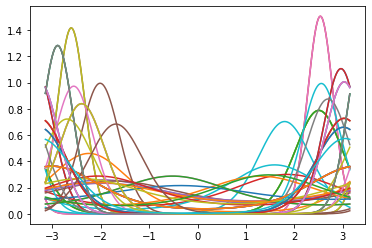

In [11]:
logq_x_r = torch.exp(log_k_dec[0,:])*torch.cos(x_fine-mu_dec[0,:]) - torch.log(modified_bessel(torch.exp(log_k_dec[0,:]),0)) - torch.log(2*torch.as_tensor(math.pi))
plt.plot(x_fine,torch.exp(logq_x_r.detach()))

In [12]:
#Full training

q = rate_ising(N)
rate = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)


In [13]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters(), enc_circ.parameters(), q.parameters())
lr = 1e-4
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(5000):
    rate = q(enc_circ,x_fine)
    dist = distortion_circular(x_fine,enc_circ,dec)
    loss = dist + rate
    opt.zero_grad()
    loss.backward()
    opt.step()
    lossVec.append(loss.item())
    rateVec.append(rate.item())
    distVec.append(dist.item())

In [14]:
#generating the q(r) (using the learned J and h)

prior_params = list(q.parameters())
h_learn = prior_params[0]# 1 x 10
J_learn = prior_params[1] # 10 x 10

In [15]:
r_all1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = r_all1.transpose()
r_all1.transpose().shape
r_all.shape

(10, 1024)

In [16]:
expo = torch.exp(torch.as_tensor(h_learn.detach().numpy()@r_all + numpy.sum(r_all*(J_learn.detach().numpy()@r_all), axis = 0)))
expo
Z = expo.sum(dim=1)
Z.shape
q_r = (1/Z)*expo


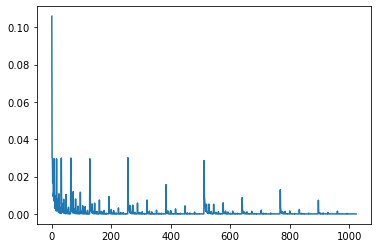

In [17]:
expo = torch.exp(torch.as_tensor(h_learn.detach().numpy()@r_all + numpy.sum(r_all*(J_learn.detach().numpy()@r_all), axis = 0)))
plt.plot(q_r[0,:].detach())

Text(0, 0.5, 'Encoding')

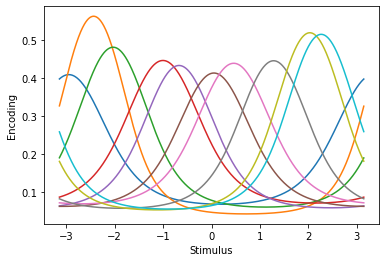

In [18]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")
#plt.xlim(-math.pi, math.pi)

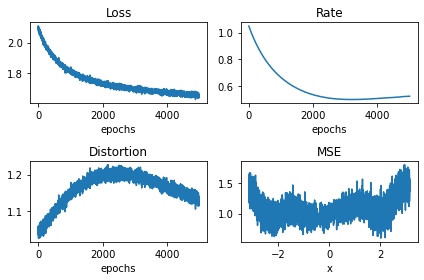

In [19]:
r = enc_circ.sample(x_sorted,50)
x_dec = dec.sample(r,50)
mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()


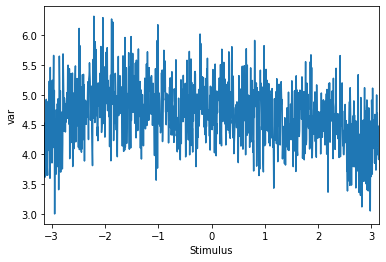

In [20]:
#variance of the decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,torch.exp(log_k_dec).mean(dim=1).detach())
    plt.ylabel("var")
    plt.xlabel("Stimulus")
    plt.xlim(-math.pi,math.pi)

Text(0.5, 0, 'Stimulus')

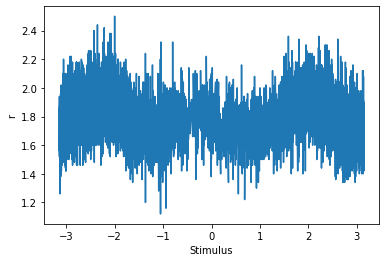

In [21]:
#Probability of each neuron to be active. The x axis is the stimulus space
a = r.sum(dim=2).mean(dim=1)
plt.plot(x_sorted, a )
plt.ylabel("r")
plt.xlabel("Stimulus")


(-3.141592653589793, 3.141592653589793)

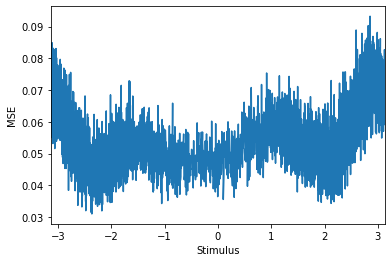

In [22]:
#Mean squared error

r = enc_circ.sample(x_sorted,50)
x_dec = dec.sample(r,100)


mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))
plt.plot(x_sorted,mseVec.detach()/20)
plt.ylabel("MSE")
plt.xlabel("Stimulus")
plt.xlim(-math.pi,math.pi)


In [23]:
#Test del modello generativo

prior_params = list(q.parameters())
h_learn = prior_params[0]# 1 x 10
J_learn = prior_params[1] # 10 x 10

r_all1 = np.asarray(list(itertools.product([0, 1], repeat=N)))

r_all1[:,None,:]
r_all = torch.as_tensor(r_all1[:,None,:], dtype = torch.float32)


mu_dec_all,log_k_dec_all = dec(r_all)


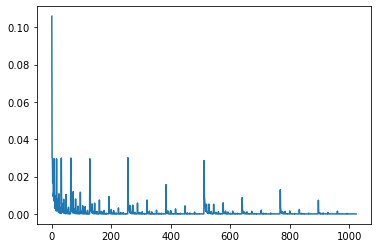

In [24]:

q_r = torch.squeeze(q_r)
plt.plot(q_r.detach())


In [34]:
weights = q_r
means = mu_dec_all
stdevs = torch.exp(log_k_dec_all)
mix = torch.distributions.categorical.Categorical(weights[1:])
compo = torch.distributions.independent.Independent(torch.distributions.von_mises.VonMises(means[1:], stdevs[1:]),0)
q_r_q_x_r = torch.distributions.mixture_same_family.MixtureSameFamily(mix, compo)

q_r_q_x_r

MixtureSameFamily(
  Categorical(probs: torch.Size([1023]), logits: torch.Size([1023])),
  Independent(VonMises(loc: torch.Size([1023]), concentration: torch.Size([1023])), 0))

In [35]:
x_samples = q_r_q_x_r.sample((N_SAMPLES,))[:,None]
x_samples.shape
x_samples = torch.squeeze(x_samples)

Text(0, 0.5, 'pdf')

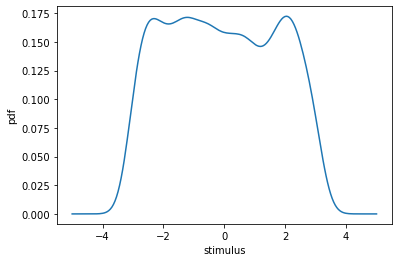

In [36]:
kde = scipy.stats.gaussian_kde(x_samples)
t_range = np.linspace(-5,5,200)
plt.plot(t_range,kde(t_range))
plt.xlabel("stimulus")
plt.ylabel("pdf")

In [33]:
weights[1,:]

IndexError: too many indices for tensor of dimension 1